### Safe deep Q-network

Have a network estimating $Q_w(s, a)$ for $-reward$, $Q^T_w(s, a)$ for stopping time $1$ iff terminal state, $Q^D_w(s, a)$ for constraint (the more the worse). $\pi$ is eps-soft of $Q$
1. Sample action and perform it
2. Sample minibatch from experience replay
3. Perform Bellman update: $\sum\limits_{s, a, r, s'}\left(r+\max_{a'}Q_{w_0}(s', a')-Q_w(s, a)\right)^2$

Networks: $Q_T, Q_D, Q, \pi$

Having collected experience D from the replay buffer:
1. Calculate current policy $\pi_k$ and Q-like functions (TensorFlow)
2. Calculate $\varepsilon$ using policy and $Q$s (TensorFlow)
3. Using policy, Q-functions and $\varepsilon$, solve LP to obtain $\pi'$ (SciPy)
4. Make a step for Bellman update using $\pi,\pi',\varepsilon,Q$ (TensorFlow)
5. Make a step towards minimizing $D_{JSD}(\pi||\pi')$ (TensorFlow)

In [1]:
from xvfbwrapper import Xvfb

#vdisplay = Xvfb()
#vdisplay.start()

# for environ
import os

# only using device 0
os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID"   # see issue #152
os.environ["LIBGL_ALWAYS_SOFTWARE"]="1"
#os.environ["CUDA_VISIBLE_DEVICES"]="0"

# importing tensorflow
import tensorflow as tf

# import scipy
import scipy, csv

import pandas as pd

# for linprog (faster than scipy...)
import pulp

In [2]:
import gym
from gym import wrappers
%matplotlib inline
from matplotlib import pyplot as plt
import numpy as np
from tqdm import tqdm

# to display environment data
# see https://gist.github.com/thomelane/79e97630ba46c45985a946cae4805885
from IPython import display

In [3]:
import sys
sys.path += ['/localhome/volodin/local/usr/bin']
sys.path

['',
 '/localhome/volodin/miniconda3/envs/neuronfailure/lib/python36.zip',
 '/localhome/volodin/miniconda3/envs/neuronfailure/lib/python3.6',
 '/localhome/volodin/miniconda3/envs/neuronfailure/lib/python3.6/lib-dynload',
 '/localhome/volodin/miniconda3/envs/neuronfailure/lib/python3.6/site-packages',
 '/localhome/volodin/miniconda3/envs/neuronfailure/lib/python3.6/site-packages/IPython/extensions',
 '/localhome/volodin/.ipython',
 '/opt/gurobi201/linux32/lib/python2.5',
 '/opt/gurobi201/linux32/lib/python2.5',
 '/localhome/volodin/local/usr/bin']

In [4]:
from xvfbwrapper import Xvfb

vdisplay = Xvfb()
vdisplay.start()

In [5]:
tf.reset_default_graph()
# allowing GPU memory growth to allocate only what we need
config = tf.ConfigProto()
config.gpu_options.per_process_gpu_memory_fraction = 0.5
config.gpu_options.allow_growth = True
sess = tf.Session(config=config, graph = tf.get_default_graph())

In [6]:
env = gym.make('CartPole-v0')

In [7]:
# number of dimensions in state
S_DIM = 4

# number of available actions
ACTIONS = 2

# discount factor
gamma_discount = 0.9

# epsilon-greedy
eps = 0.1

# for softmax
temperature = 5

In [8]:
# states: double the length of actions: from-to-from-to...
states = tf.placeholder(tf.float64, shape = (None, S_DIM,))

# taken actions
actions = tf.placeholder(tf.int64, shape = (None,))

# rewards obtained
rewards = tf.placeholder(tf.float64, shape = (None,))

# costs obtained
costs = tf.placeholder(tf.float64, shape = (None, ))

# is step terminal?
termination = tf.placeholder(tf.float64, shape = (None, ))

# need next q-value (non-terminal state?)
need_next_q = tf.placeholder(tf.float64, shape = (None, ))

# new policy pi'
logits_new_policy = tf.placeholder(tf.float64, shape = (None, ACTIONS))

def fc_layer(x, n, activation = tf.nn.relu):
    """ Fully connected layer for input x and output dim n """
    return tf.contrib.layers.fully_connected(x, n, activation_fn=activation,
    weights_initializer=tf.initializers.lecun_normal(), weights_regularizer=None,
    biases_initializer=tf.zeros_initializer(), biases_regularizer=None, trainable=True)

In [9]:
class ExperienceReplay():
    def __init__(self, N = 1000):
        """ Create experience buffer with capacity N """
        self.N = N
        self.buf = []
    def store(self, exp):
        """ Store one experience """
        self.buf.append(exp)
        
        # removing extra elements
        extra = len(self.buf) - self.N
        if extra > 0:
            self.buf = self.buf[extra:]
            
    def sample(self, how_many = 10):
        """ Sample a mini-batch from the buffer """
        assert len(self.buf) > 0, "Experience buffer is empty, cannot sample"
        indices = np.random.choice(len(self.buf), how_many)
        result = [self.buf[i] for i in indices]
        return result

In [10]:
common_layer = states#fc_layer(states, 20)

In [11]:
def q_like_function(z = common_layer):

    # state is an input to the network
    #z = states

    # some fully connected stuff
    z = fc_layer(z, 20)

    # some fully connected stuff
    #z = fc_layer(z, 10)

    # Q network head
    with tf.name_scope('q_layers'):
        #z = fc_layer(z, 10)
        z_policy = fc_layer(z, 10)
        z_policy = fc_layer(z_policy, ACTIONS, activation = None)
        q_values = z_policy
        #logits_policy = tf.nn.softmax(z_policy)
        # predicted labels
        logits_policy = tf.nn.softmax(temperature * q_values)
    return q_values, logits_policy

In [12]:
# maximal constraint violation
d0 = tf.placeholder(tf.float64)

In [13]:
q_reward, _ = q_like_function()
q_termination, _ = q_like_function()
q_cost, _ = q_like_function()

In [14]:
_, logits_policy = q_like_function()
# taken logits (from state)
logits_from = logits_policy[0::2]
def dot_and_sum1(Z1, Z2):
    """ Return a vector of length Z1.shape[0] == Z2.shape[0] with i'th entry being sum of Z1ik*Z2ik """
    return tf.reduce_sum(tf.multiply(Z1, Z2), axis = 1)
eps_lyapunov = d0 - dot_and_sum1(logits_policy, q_cost) / dot_and_sum1(logits_policy, q_termination)
q_lyapunov = q_cost + tf.multiply(q_termination, tf.expand_dims(eps_lyapunov, 1))

In [15]:
def mse(x, y):
    """ Mean squared error tensor """
    return tf.reduce_mean(tf.square(x - y))

In [16]:
def soft_bellman_loss(actions, rewards, q_values_from_to, logits_policy, need_next_q):
    """ Bellman residual w.r.t. actions, rewards and q-values """
    # q-values from-to, equal length
    q_values_from = q_values_from_to[0::2, :]
    q_values_to = q_values_from_to[1::2, :]

    # one-hot encoded actions
    a_one_hot = tf.one_hot(actions, ACTIONS)

    # taken Q value (from)
    q_taken = tf.boolean_mask(q_values_from, a_one_hot)

    # maximal Q value
    # TODO: replace with soft (use logits!)
    #q_max   = tf.reduce_max(tf.stop_gradient(q_values_to), axis = 1)
    q_soft = dot_and_sum1(tf.stop_gradient(q_values_to), logits_policy)
    
    # loss tensor
    loss = mse(rewards + gamma_discount * tf.multiply(need_next_q, q_soft), q_taken)
    return loss

In [17]:
def cost(obs):
    """ Calculate scalar cost of one observation """
    assert isinstance(obs, np.ndarray) and obs.shape == (4,), "Input must be an np-array [x xdot phi phidot]"
    
    # parsing input
    x, x_dot, phi, phi_dot = obs
    
    #X_MAX = 1.0
    #X_DOT_MAX = 0.5
    #PHI_MAX = 0.1
    #PHI_DOT_MAX = 0.5
    
    if x < 0 or phi < 0:
        return 1
    
    #if np.any(np.abs([x, x_dot, phi, phi_dot]) > [X_MAX, X_DOT_MAX, PHI_MAX, PHI_DOT_MAX]):
    #    return 1
    
    # in all other cases no cost
    return 0

In [18]:
# Bellmann losses
loss_r = soft_bellman_loss(actions, rewards, q_reward, logits_new_policy, need_next_q)
#loss_r = soft_bellman_loss(actions, rewards, q_reward, logits_reward[0::2], need_next_q)
loss_d = soft_bellman_loss(actions, costs, q_cost, logits_from, need_next_q)
loss_t = soft_bellman_loss(actions, termination, q_termination, logits_from, need_next_q)

In [19]:
loss_bellman = loss_r + loss_d + loss_t

In [20]:
# Jensen-Shannon Divergence
# D_{JS}(P, Q) = 0.5 * D_KL(P || M) + 0.5 * D_KL(Q || M)
# M = 0.5 * (P + Q) -> normalized!
def kl(x, y):
    """ KL-divergence """
    X = tf.distributions.Categorical(probs=x)
    Y = tf.distributions.Categorical(probs=y)
    return tf.distributions.kl_divergence(X, Y)
def jsd(x, y):
    M = 0.5 * (x + y)
    return 0.5 * kl(x, M) + 0.5 * kl(y, M)

In [21]:
# logits of policy (taken, from original state)
loss_jsd = tf.reduce_mean(jsd(logits_from, logits_new_policy))

In [22]:
params = tf.trainable_variables()

In [23]:
def replay_test():
    replay = ExperienceReplay()
    replay.store([1,2])
    replay.store([3,4])
    rs = replay.sample()
    assert [1,2] in rs or [3,4] in rs
    
    replay = ExperienceReplay(N = 3)

    replay.store(1)
    replay.store(2)
    replay.store(3)
    replay.store(4)
    replay.store(5)
    replay.store(6)

    assert replay.buf == [4, 5, 6]
replay_test()

In [24]:
def sample_action(observation):
    """ Sample an action from the policy """
    
    if np.random.random() <= eps:
        return env.action_space.sample()
    
    p = sess.run(logits_policy, feed_dict = {states: [observation]})[0]
    #p = sess.run(logits_reward, feed_dict = {states: [observation]})[0]
    
    # argmax for q-function
    #return np.argmax(p)

    # choice for real policy
    return np.random.choice(range(2), p = p)

In [25]:
def get_rollout():
    """ Obtain rollout using policy """
    done = False
    observation = env.reset()
    sarsnc = []
    # S: from state
    # A: action
    # R: reward obtained
    # S: new state
    # N: true if need next (non-terminal)
    # C: cost obtained
    while not done:
        act = sample_action(observation)
        observation_, reward, done, info = env.step(act) # take a random action
        curr = (observation, act, reward, observation_, True, cost(observation_))
        sarsnc.append(curr)
        replay.store(curr)
        
        if done:
            # crucial, otherwise Q blows up...
            replay.store((observation_, sample_action(observation_), reward, observation_, False, cost(observation_)))
        
        observation = observation_
    env.close()
    #print(len(replay.buf), len(sars))
    return sarsnc

In [26]:
#loss = loss_bellman
#loss = loss_r
loss = loss_bellman + loss_jsd
opt = tf.train.AdamOptimizer(0.1).minimize(loss)

/localhome/volodin/miniconda3/envs/neuronfailure/lib/python3.6/site-packages/tensorflow/python/ops/gradients_impl.py:112: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


In [27]:
# one learning iteration
step = opt

In [28]:
def interleave(A, B):
    """ Interleave two lists A, B: a1b1a2b2... """
    # https://stackoverflow.com/questions/7946798/interleave-multiple-lists-of-the-same-length-in-python
    assert len(A) == len(B), "Must have arrays of same length"
    return [val for tup in zip(A, B) for val in tup]
assert interleave([1,2,3],[4,5,6]) == [1, 4, 2, 5, 3, 6]

In [29]:
init = tf.global_variables_initializer()
sess.run(init)
r = []

## optimization problem:
1. $\pi'$ probability distribution: $\pi_i\geq 0$ and $\sum\pi_i=1$
2. $\pi^TQ_R\to\max$
3. s.t. $(\pi-\pi_k)^TQ_L\leq\varepsilon$

In [30]:
def train_step(L = 200, d0_ = 50):
    # sampling same size
    S0, A, R, S1, N, C = list(zip(*replay.sample(L)))
    
    # taking some data from the environment (sampling...)
    #S0, A, R, S1, N, C = zip(*get_rollout())

    # converting to float
    N = 1. * np.array(N)

    # feed dictionary for TF
    feed = {states: interleave(S0, S1), actions: A, rewards: R, costs: C,
            d0: d0_, need_next_q: N, termination: 1 - N}

    # obtaining current policy
    pi_k, q_L, q_R, eps_L = sess.run((logits_from, q_lyapunov, q_reward, eps_lyapunov), feed_dict = feed)
    
    # taking FROM for q_L, q_R, eps_L
    q_L = q_L[0::2,:]
    q_R = q_R[0::2,:]
    eps_L = eps_L[0::2]
    
    # sanity check for length
    assert len(q_L) == len(q_R) == len(eps_L) == N

    # lower/upper bound for variables
    lb, ub = 0.0, 1.0
    
    # number of variables: |A| * |Batch|
    n_vars = (pi_k.shape[0] * ACTIONS)
    
    # new policy is initialy None
    pi_new = None
    
    # solving the LP
    # Use https://docs.scipy.org/doc/scipy/reference/generated/scipy.optimize.linprog.html
    # to solve a linear program
    try:
        # creating a maximization problem
        prob = pulp.LpProblem("policy", pulp.LpMaximize)
        
        # creating variables lb <= x_i <= ub
        x = pulp.LpVariable.dicts('x', range(n_vars), lowBound=lb, upBound = ub)
        
        # flattening q_R S1A1 S1A2 S2A1 S2A2 ...
        q_Rf = q_R.flatten()
        
        # all variables flattened
        x_vars = [x[i] for i in range(n_vars)]
        
        # adding objective: (Q_R, x)
        prob += pulp.lpSum([Ri * xi for Ri, xi in zip(q_Rf, x_vars)]), "objective"
        
        # sanity check for length
        assert len(q_Rf) == len(x_vars)
        
        # adding constraints
        for i in range(n_vars // ACTIONS):
            # adding probability constraint
            prob += pulp.lpSum([x[2 * i], x[2 * i + 1]]) == 1.0
            
            # NOT including safety...
            continue
            
            cqL = q_L[i, 0]
            cqR = q_L[i, 1]
            xL = x[2 * i]
            xR = x[2 * i + 1]
            prob += pulp.lpSum(xL * cqL + xR * cqR) <= eps_L[i] + pi_k[i,0] * cqL + pi_k[i,1] * cqR

        # solving the problem
        status = prob.solve()
        
        # obtaining new policy
        pi_new = [xx.value() for xx in x_vars]
        #print(pulp.LpStatus[status])
    #except:
        # otherwise, it's N
        #pi_new = float('nan')

    # if no new policy, assign it to old policy
    if np.isnan(np.linalg.norm(pi_new)):
        #print('Optimization for pi failed... Only doing Bellman update')
        pi_new = pi_k
    else:
        # if item is 0, replace it to this
        # to fix KL divergence blowing up
        kl_eps = 1e-5

        # fixing kl_eps
        pi_new[pi_new == 0] = kl_eps

        # next policy (zipping back)
        pi_new = np.array([pi_new[0::2], pi_new[1::2]]).T

    # adding data to FEED dict
    feed[logits_new_policy] = pi_new
    
    # training...
    sess.run(step, feed_dict = feed)
    
    return np.sum(R), np.sum(C)

In [31]:
def get_current_eps(eps_decay, iteration):
    # finding minimal key s.t. <= iteration
    for key in sorted(eps_decay.keys(), reverse = True):
        if key <= iteration:
            return eps_decay[key]
    print("Error: could not find eps")
    return None

def test_decay():
    eps_decay = {0: 0.9, 100: 0.5, 200: 0.3, 300: 0.1, 500: 0}
    assert get_current_eps(eps_decay, 499) == 0.1
    assert get_current_eps(eps_decay, 1000) == 0
    assert get_current_eps(eps_decay, 500) == 0
    assert get_current_eps(eps_decay, 100) == 0.5
    assert get_current_eps(eps_decay, 0) == 0.9
test_decay()

In [32]:
eps_decay = {0: 0.9, 400: 0.5, 600: 0.3, 800: 0.2, 900: 0.1, 1000: 0.05, 1100: 0}

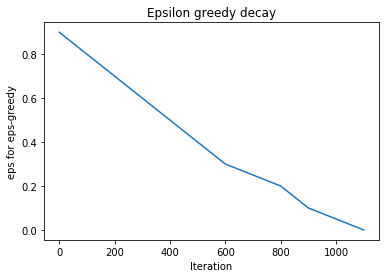

In [33]:
plt.title('Epsilon greedy decay')
plt.ylabel('eps for eps-greedy')
plt.xlabel('Iteration')
plt.plot(eps_decay.keys(), eps_decay.values())
plt.show()

In [34]:
init = tf.global_variables_initializer()
sess.run(init)
replay = ExperienceReplay(N = 10000)
r = []
c = []

In [35]:
for i in tqdm(range(1000)):
    # obtaining current epsilon for exploration
    eps = get_current_eps(eps_decay, i)
    
    # obtaining rollout
    for i in range(2):
        sarsnc = get_rollout()
        _, _, R, _, _, C = zip(*sarsnc)
        r.append(np.sum(R))
        c.append(np.sum(C))
        
    # training the agent
    train_step(L = 1000, d0_ = 1000)
    #print(len(replay.buf))

100%|██████████| 1000/1000 [02:22<00:00,  8.34it/s]


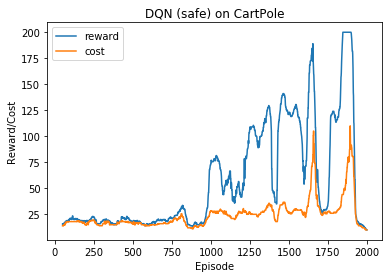

In [36]:
plt.figure()
plt.title('DQN (safe) on CartPole')
plt.plot(pd.DataFrame(r).rolling(50).median(), label = 'reward')
plt.plot(pd.DataFrame(c).rolling(50).median(), label = 'cost')
plt.xlabel('Episode')
plt.ylabel('Reward/Cost')
plt.savefig('sdqn.eps', bbox_inches = 'tight')
plt.legend()
plt.show()

Weird that the agent unlearns everything for some reason. What works and doesn't work:
1. Bellman (b) + JSD (j) + log_r for action selection - 
2. b log_r -
3. r log_r +- (goes up/down)
4. b + j log_pi no
5. r log_r log_r in R loss NO ??? also, reward doesn't go down with exploration?.. fixed when sampling argmax instead of sampling. For q-logits the policy should be argmax!, works
6. B log_r log_r argmax + (now -???..)
6. B+J log_r log_r argmax - ??? Why just adding a loss makes it worse? Are they scaled inappropriately? Or are they using the same layer making it follow two tasks? Want to be confident when solving this... It immediately made me solve this problems and spot the odd thing. It's so much more productive than monkey-coding. Why did I switch to it? It makes sense it doesn't work since I use soft Bellman loss
8. B log_r x 2 no common layer kinda, -

Hypothesis: experience replay is not implemented correctly. Check all equations. heck what target pi' is.

**19th May** I think it shouldn't work because soft bellman loss wouldn't work for q-logits which are approximately the same

Trying to make policy network to work...
1. Mistake in call to pulp: first argument was treated as name and not as Maximize
2. And it fucking works!

In [41]:
len(get_rollout())

9

In [38]:
#env = env.unwrapped
#env = gym.wrappers.Monitor(env, './video')
#get_rollout()
#sess.run(params)
#tf.train.Saver().save(sess, './cartpole-h1.ckpt')
#tf.train.Saver().restore(sess, './cartpole-h1.ckpt')